# Predikcija proizvodnje i potrošnje električne energije na osnovu vremenskih uslova i doba dana

## Uvod

Obnovljivi izvori energije imaju sve važniju ulogu u savremenim elektroenergetskim sistemima, ali njihova proizvodnja u velikoj mjeri zavisi od vremenskih uslova i doba dana. Faktori poput temperature, sunčevog zračenja i brzine vjetra direktno utiču na količinu proizvedene električne energije. S druge strane, i potražnja za električnom energijom pokazuje određene obrasce u zavisnosti od istih parametara.

Cilj ovog projekta je ispitati kako vremenski uslovi i doba dana utiču na proizvodnju električne energije iz obnovljivih izvora, kao i analizirati u kojoj mjeri isti faktori utiču na potražnju za električnom energijom.

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import xgboost as xgb

In [5]:
df = pd.read_csv("weather_features.csv")
df = df[['dt_iso', 'city_name', 'wind_speed', 'wind_deg', 'clouds_all', 'weather_main', 'weather_description', 'weather_id', 'humidity', 'pressure', 'temp']].copy()
df

,dt_iso,city_name,wind_speed,wind_deg,clouds_all,weather_main,weather_description,weather_id,humidity,pressure,temp
0,2015-01-01 00:00:00+01:00,Valencia,1,62,0,clear,sky is clear,800,77,1001,270.475
1,2015-01-01 01:00:00+01:00,Valencia,1,62,0,clear,sky is clear,800,77,1001,270.475
2,2015-01-01 02:00:00+01:00,Valencia,0,23,0,clear,sky is clear,800,78,1002,269.686
3,2015-01-01 03:00:00+01:00,Valencia,0,23,0,clear,sky is clear,800,78,1002,269.686
4,2015-01-01 04:00:00+01:00,Valencia,0,23,0,clear,sky is clear,800,78,1002,269.686
...,...,...,...,...,...,...,...,...,...,...,...
178391,2018-12-31 19:00:00+01:00,Seville,3,30,0,clear,sky is clear,800,54,1028,287.760
178392,2018-12-31 20:00:00+01:00,Seville,3,30,0,clear,sky is clear,800,62,1029,285.760
178393,2018-12-31 21:00:00+01:00,Seville,4,50,0,clear,sky is clear,800,58,1028,285.150
178394,2018-12-31 22:00:00+01:00,Seville,4,60,0,clear,sky is clear,800,57,1029,284.150


In [6]:
unique_descriptions = df['weather_description'].unique()
unique_ids = df['weather_id'].unique()

print(f"Ukupno ima {len(unique_ids)} različitih idjeva vremena:\n")
print(f"Ukupno ima {len(unique_descriptions)} različitih opisa vremena:\n")
for desc in unique_descriptions:
    print(f"- {desc}")

Ukupno ima 38 različitih idjeva vremena:

Ukupno ima 43 različitih opisa vremena:

- sky is clear
- few clouds
- scattered clouds
- broken clouds
- overcast clouds
- light rain
- moderate rain
- heavy intensity rain
- mist
- heavy intensity shower rain
- shower rain
- very heavy rain
- thunderstorm with heavy rain
- thunderstorm with light rain
- thunderstorm with rain
- proximity thunderstorm
- thunderstorm
- light intensity shower rain
- light intensity drizzle
- fog
- drizzle
- smoke
- heavy intensity drizzle
- haze
- proximity shower rain
- light intensity drizzle rain
- light snow
- rain and snow
- light rain and snow
- snow
- light thunderstorm
- heavy snow
- sleet
- rain and drizzle
- shower sleet
- light shower sleet
- light shower snow
- proximity moderate rain
- ragged shower rain
- sand dust whirls
- proximity drizzle
- dust
- squalls


In [8]:
print(df.columns[df.isnull().any()])

Index([], dtype='str')


In [9]:
df_energy = pd.read_csv("energy_dataset.csv")
df_energy = df_energy[['time', 'generation solar', 'generation wind onshore', 'total load actual']].copy()
df_energy

,time,generation solar,generation wind onshore,total load actual
0,2015-01-01 00:00:00+01:00,49.0,6378.0,25385.0
1,2015-01-01 01:00:00+01:00,50.0,5890.0,24382.0
2,2015-01-01 02:00:00+01:00,50.0,5461.0,22734.0
3,2015-01-01 03:00:00+01:00,50.0,5238.0,21286.0
4,2015-01-01 04:00:00+01:00,42.0,4935.0,20264.0
...,...,...,...,...
35059,2018-12-31 19:00:00+01:00,85.0,3113.0,30653.0
35060,2018-12-31 20:00:00+01:00,33.0,3288.0,29735.0
35061,2018-12-31 21:00:00+01:00,31.0,3503.0,28071.0
35062,2018-12-31 22:00:00+01:00,31.0,3586.0,25801.0


In [10]:
print(df_energy.columns[df_energy.isnull().any()])

Index(['generation solar', 'generation wind onshore', 'total load actual'], dtype='str')


In [11]:
total_rows = len(df_energy)
missing_percentage = (df_energy.isnull().sum() / total_rows) * 100

print("\nProcenat nedostajućih vrednosti:")
print(missing_percentage[missing_percentage > 0].round(2).astype(str) + '%')

df_energy['generation solar'] = df_energy['generation solar'].ffill()
df_energy['generation wind onshore'] = df_energy['generation wind onshore'].ffill()
df_energy['total load actual'] = df_energy['total load actual'].ffill()




Procenat nedostajućih vrednosti:
generation solar           0.05%
generation wind onshore    0.05%
total load actual           0.1%
dtype: str


Moramo osigurati da oba DataFrame-a imaju isto ime kolone za vreme

In [12]:
df_energy = df_energy.rename(columns={'time': 'dt_iso'})

df_energy['dt_iso'] = pd.to_datetime(df_energy['dt_iso'], utc=True)
df['dt_iso'] = pd.to_datetime(df['dt_iso'], utc=True)

Da bismo imali jedan red po satu, moramo raširiti gradove u kolone. Tako ćemo u jednom redu imati temperaturu i vetar za Madrid, Bilbao, Sevilju, Barselonu i Valensiju. Za neke gradove su postojali duplikati vremenskih zapisa za isti sat, pa je bilo potrebno izbrisati duplikate.

In [13]:
df = df[['dt_iso', 'city_name', 'wind_speed', 'wind_deg', 'clouds_all', 'weather_id', 'humidity', 'pressure', 'temp']].copy()

df = df.drop_duplicates(subset=['dt_iso', 'city_name'])

df['city_name'] = df['city_name'].str.strip()
df_weather_wide = df.pivot(index='dt_iso', columns='city_name')

df_weather_wide.columns = [f'{col[0]}_{col[1]}' for col in df_weather_wide.columns]
df_weather_wide = df_weather_wide.reset_index()

df_final = pd.merge(df_weather_wide, df_energy, on='dt_iso', how='inner')

In [14]:
df_final = pd.merge(df_weather_wide, df_energy, on='dt_iso', how='inner')

print(f"Dimenzije spojenog fajla: {df_final.shape}")

print(df_final.columns.tolist())

Dimenzije spojenog fajla: (35064, 39)
['dt_iso', 'wind_speed_Barcelona', 'wind_speed_Bilbao', 'wind_speed_Madrid', 'wind_speed_Seville', 'wind_speed_Valencia', 'wind_deg_Barcelona', 'wind_deg_Bilbao', 'wind_deg_Madrid', 'wind_deg_Seville', 'wind_deg_Valencia', 'clouds_all_Barcelona', 'clouds_all_Bilbao', 'clouds_all_Madrid', 'clouds_all_Seville', 'clouds_all_Valencia', 'weather_id_Barcelona', 'weather_id_Bilbao', 'weather_id_Madrid', 'weather_id_Seville', 'weather_id_Valencia', 'humidity_Barcelona', 'humidity_Bilbao', 'humidity_Madrid', 'humidity_Seville', 'humidity_Valencia', 'pressure_Barcelona', 'pressure_Bilbao', 'pressure_Madrid', 'pressure_Seville', 'pressure_Valencia', 'temp_Barcelona', 'temp_Bilbao', 'temp_Madrid', 'temp_Seville', 'temp_Valencia', 'generation solar', 'generation wind onshore', 'total load actual']


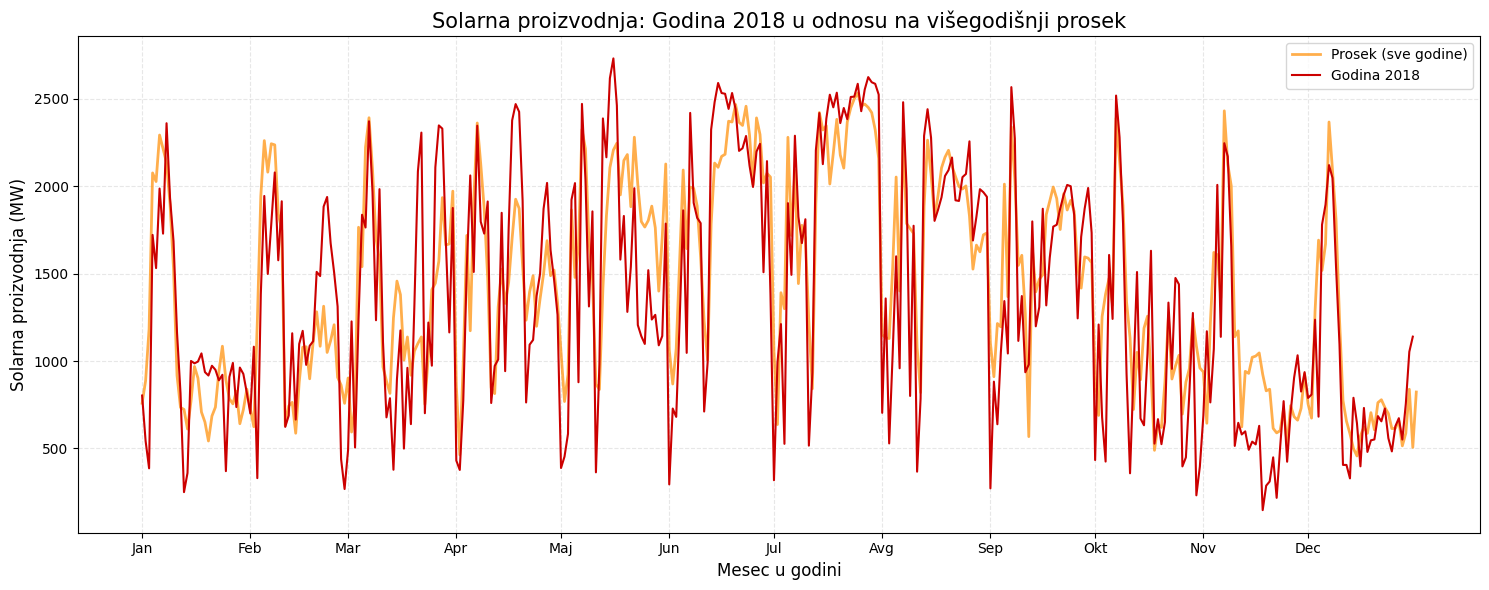

In [ ]:


# 1. Priprema podataka
df_line = df_final.copy()
df_line['dt_iso'] = pd.to_datetime(df_line['dt_iso'], utc=True)
df_line['Year'] = df_line['dt_iso'].dt.year
df_line['Day_of_Year'] = df_line['dt_iso'].dt.dayofyear

# 2. Grupisanje na dnevni nivo
# Prvo dobijemo dnevni prosek za svaki specifičan dan u svakoj godini
df_daily = df_line.groupby(['Year', 'Day_of_Year'])['generation solar'].mean().reset_index()

# 3. Računanje opšteg proseka za sve tri godine (po danu u godini)
df_average = df_daily.groupby('Day_of_Year')['generation solar'].mean().reset_index()

# 4. Filtriramo jednu specifičnu godinu (npr. 2018 ili poslednju dostupnu)
izabrana_godina = df_daily['Year'].max()
df_specific_year = df_daily[df_daily['Year'] == izabrana_godina]

# 5. Crtanje
plt.figure(figsize=(15, 6))

# Linija proseka (Narandžasta) - deblja i malo prozirna da bude "pozadina"
plt.plot(df_average['Day_of_Year'], df_average['generation solar'], 
         color='#FF8C00', label='Prosek (sve godine)', linewidth=2, alpha=0.7)

# Linija specifične godine (Crvena) - istaknuta
plt.plot(df_specific_year['Day_of_Year'], df_specific_year['generation solar'], 
         color='#CC0000', label=f'Godina {izabrana_godina}', linewidth=1.5)

plt.title(f'Solarna proizvodnja: Godina {izabrana_godina} u odnosu na višegodišnji prosek', fontsize=15)
plt.xlabel('Mesec u godini', fontsize=12)
plt.ylabel('Solarna proizvodnja (MW)', fontsize=12)

# Podešavanje X ose na mesece
plt.xticks(ticks=[1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335],
           labels=['Jan', 'Feb', 'Mar', 'Apr', 'Maj', 'Jun', 'Jul', 'Avg', 'Sep', 'Okt', 'Nov', 'Dec'])

plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

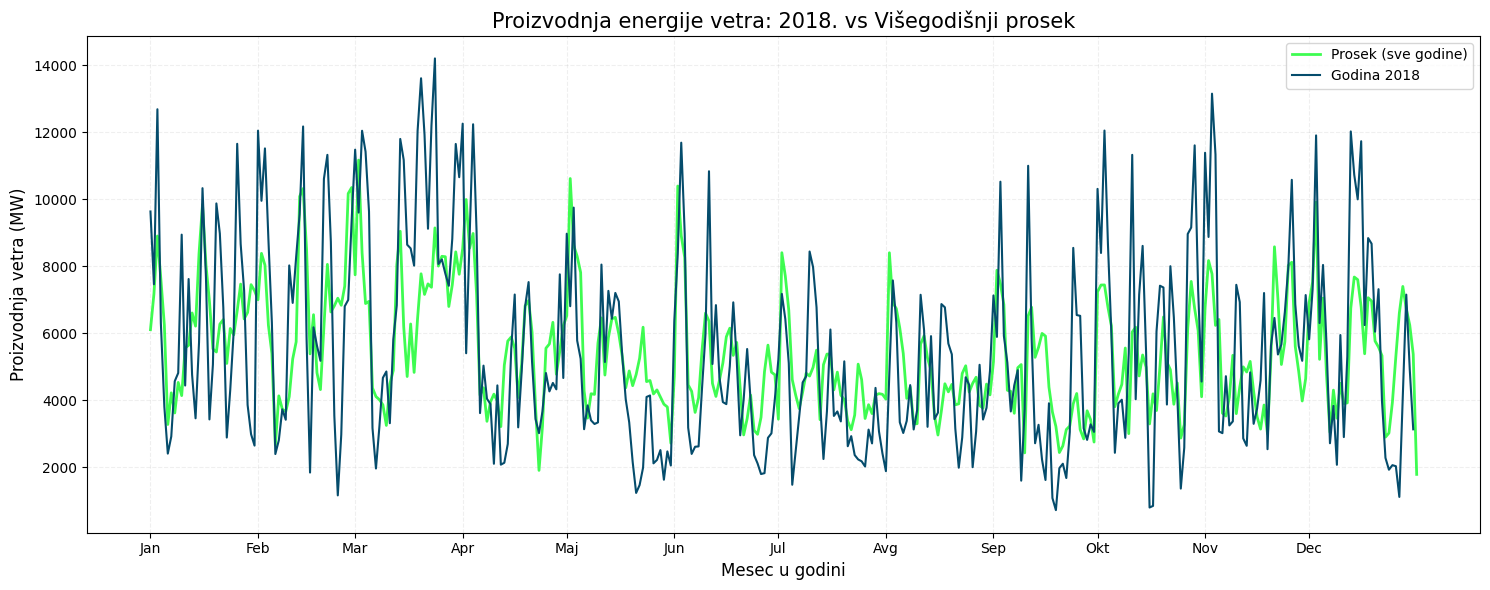

In [ ]:

df_line_wind = df_final.copy()
df_line_wind['dt_iso'] = pd.to_datetime(df_line_wind['dt_iso'], utc=True)
df_line_wind['Year'] = df_line_wind['dt_iso'].dt.year
df_line_wind['Day_of_Year'] = df_line_wind['dt_iso'].dt.dayofyear

# 2. Grupisanje na dnevni nivo za vetar
df_daily_wind = df_line_wind.groupby(['Year', 'Day_of_Year'])['generation wind onshore'].mean().reset_index()

# 3. Računanje opšteg proseka za sve godine
df_avg_wind = df_daily_wind.groupby('Day_of_Year')['generation wind onshore'].mean().reset_index()

# 4. Filtriranje 2018. godine
df_2018 = df_daily_wind[df_daily_wind['Year'] == 2018]

# 5. Crtanje
plt.figure(figsize=(15, 6))

# Prosek (Svetlija siva) - "pozadinska" linija
plt.plot(df_avg_wind['Day_of_Year'], df_avg_wind['generation wind onshore'], 
         color="#0EFC26", label='Prosek (sve godine)', linewidth=2, alpha=0.8)

# Godina 2018 (Tamnoplava) - istaknuta linija
plt.plot(df_2018['Day_of_Year'], df_2018['generation wind onshore'], 
         color='#054C6C', label='Godina 2018', linewidth=1.5)

plt.title('Proizvodnja energije vetra: 2018. vs Višegodišnji prosek', fontsize=15)
plt.xlabel('Mesec u godini', fontsize=12)
plt.ylabel('Proizvodnja vetra (MW)', fontsize=12)

# Podešavanje X ose na mesece
plt.xticks(ticks=[1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335],
           labels=['Jan', 'Feb', 'Mar', 'Apr', 'Maj', 'Jun', 'Jul', 'Avg', 'Sep', 'Okt', 'Nov', 'Dec'])

plt.grid(True, linestyle='--', alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()

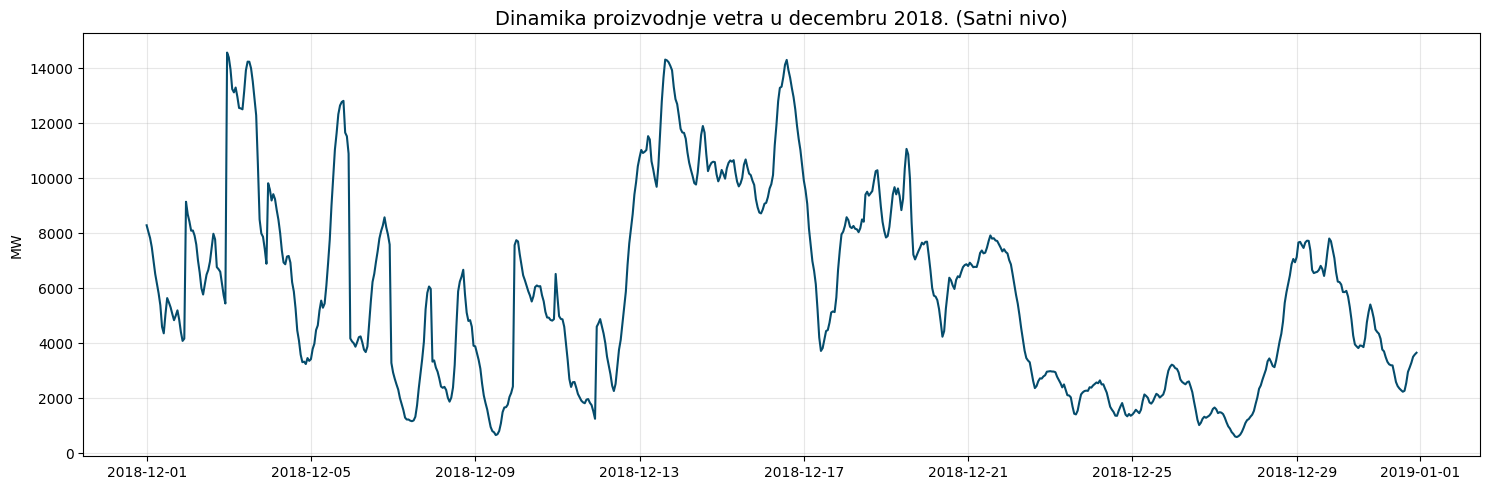

In [ ]:
# Filtriramo decembar 2018.
df_december = df_line_wind[(df_line_wind['Year'] == 2018) & (df_line_wind['dt_iso'].dt.month == 12)]

plt.figure(figsize=(15, 5))
plt.plot(df_december['dt_iso'], df_december['generation wind onshore'], color='#054C6C', linewidth=1.5)

plt.title('Dinamika proizvodnje vetra u decembru 2018. (Satni nivo)', fontsize=14)
plt.ylabel('MW')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Uzeti su podaci u vremenskom rasponu od 9h do 18h da noćni sati ne bi uticali na grafik jer svakako ne utiču na proizvodnju solarne električne energije.

Broj redova nakon filtriranja: 14610


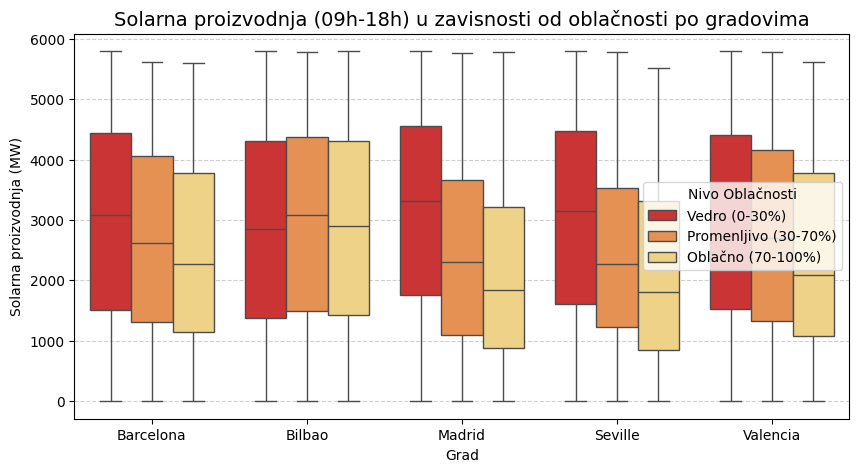

In [ ]:
df_plot = df_final.copy()

df_plot['dt_iso'] = pd.to_datetime(df_plot['dt_iso'], utc=True)
df_plot.set_index('dt_iso', inplace=True)

df_plot.index = df_plot.index.tz_localize(None)
df_filtered = df_plot.between_time('09:00', '18:00')

print(f"Broj redova nakon filtriranja: {len(df_filtered)}")

if len(df_filtered) > 0:
    cloud_cols = ['clouds_all_Barcelona', 'clouds_all_Bilbao', 'clouds_all_Madrid', 'clouds_all_Seville', 'clouds_all_Valencia']
    
    df_melted = df_filtered.melt(id_vars=['generation solar'], 
                                 value_vars=cloud_cols, 
                                 var_name='Grad', 
                                 value_name='Oblacnost')
    
    df_melted['Grad'] = df_melted['Grad'].str.replace('clouds_all_', '')
    
    df_melted['Nivo Oblačnosti'] = pd.cut(df_melted['Oblacnost'], 
                                         bins=[-1, 30, 70, 101], 
                                         labels=['Vedro (0-30%)', 'Promenljivo (30-70%)', 'Oblačno (70-100%)'])
    
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='Grad', y='generation solar', hue='Nivo Oblačnosti', data=df_melted, palette='YlOrRd_r')
    
    plt.title('Solarna proizvodnja (09h-18h) u zavisnosti od oblačnosti po gradovima', fontsize=14)
    plt.ylabel('Solarna proizvodnja (MW)')
    plt.xlabel('Grad')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()
else:
    print("Proveri kolonu 'dt_iso', i dalje nema podataka nakon filtriranja.")

Promene u oblačnosti zasnovane na merenjima u Madridu i Sevilji najviše utiču na proizvodnju električne energije. Možemo zaključiti da se u tim predelima nalaze najveći centri za proizvodnju solarne električne energije. Na proizvodnju solarne električne energije najmanje utiču promene u Bilbau.

Broj redova nakon filtriranja: 14610


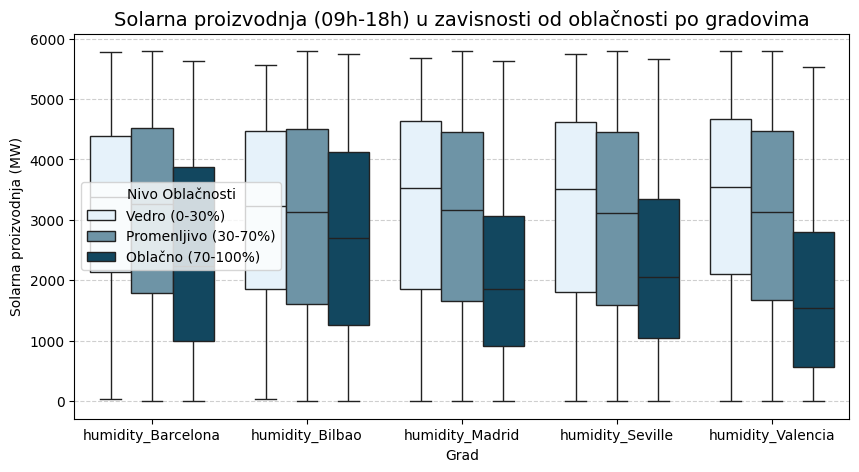

In [ ]:
df_plot = df_final.copy()

custom_palette = ["#E3F2FD", "#6497B0", "#054C6C"]

df_plot['dt_iso'] = pd.to_datetime(df_plot['dt_iso'], utc=True)
df_plot.set_index('dt_iso', inplace=True)

df_plot.index = df_plot.index.tz_localize(None)
df_filtered = df_plot.between_time('09:00', '18:00')

print(f"Broj redova nakon filtriranja: {len(df_filtered)}")

if len(df_filtered) > 0:
    cloud_cols = ['humidity_Barcelona', 'humidity_Bilbao', 'humidity_Madrid', 'humidity_Seville', 'humidity_Valencia']
    
    df_melted = df_filtered.melt(id_vars=['generation solar'], 
                                 value_vars=cloud_cols, 
                                 var_name='Grad', 
                                 value_name='Oblacnost')
    
    df_melted['Grad'] = df_melted['Grad'].str.replace('clouds_all_', '')
    
    df_melted['Nivo Oblačnosti'] = pd.cut(df_melted['Oblacnost'], 
                                         bins=[-1, 30, 70, 101], 
                                         labels=['Vedro (0-30%)', 'Promenljivo (30-70%)', 'Oblačno (70-100%)'])
    
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='Grad', y='generation solar', hue='Nivo Oblačnosti', data=df_melted, palette=custom_palette)
    
    plt.title('Solarna proizvodnja (09h-18h) u zavisnosti od oblačnosti po gradovima', fontsize=14)
    plt.ylabel('Solarna proizvodnja (MW)')
    plt.xlabel('Grad')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()
else:
    print("Proveri kolonu 'dt_iso', i dalje nema podataka nakon filtriranja.")

Vlažnost vazduha može takođe uticati na proizvodnju solarne električne energije, jer usled male pokrivenosti neba oblacima a veće vlažnosti vazduga, proizvodnja solarne električne energije može znatno da opadne

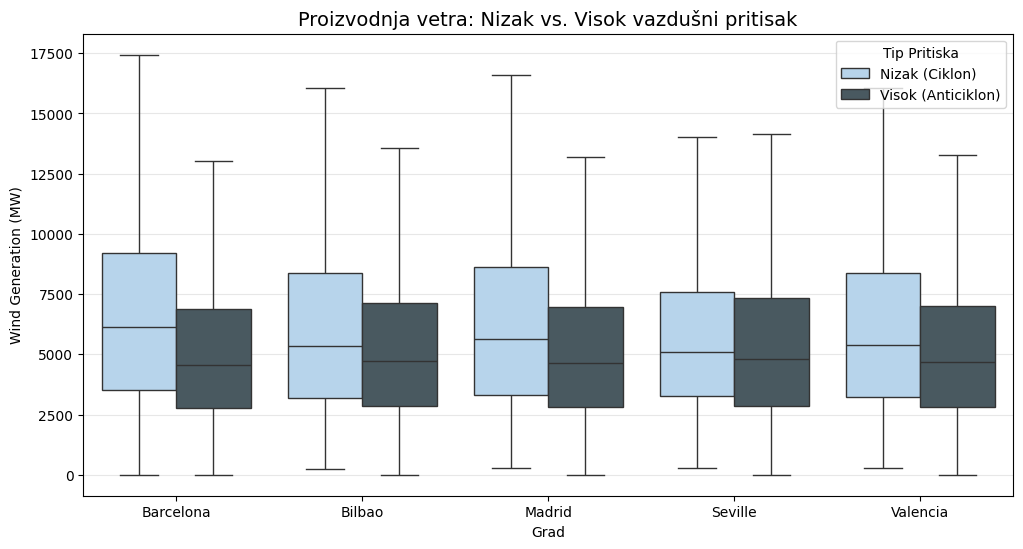

In [ ]:
# 1. Priprema i filtriranje (kao i do sada)
df_plot = df_final.copy()
df_plot['dt_iso'] = pd.to_datetime(df_plot['dt_iso'], utc=True)
df_plot.set_index('dt_iso', inplace=True)
df_plot.index = df_plot.index.tz_localize(None)

df_filtered = df_plot.copy() 

if len(df_filtered) > 0:
    pressure_cols = ['pressure_Barcelona', 'pressure_Bilbao', 'pressure_Madrid', 'pressure_Seville', 'pressure_Valencia']
    
    df_melted = df_filtered.melt(id_vars=['generation wind onshore'], 
                                 value_vars=pressure_cols, 
                                 var_name='Grad', 
                                 value_name='Pritisak')
    
    df_melted['Grad'] = df_melted['Grad'].str.replace('pressure_', '')

    df_melted['Tip Pritiska'] = pd.cut(df_melted['Pritisak'], 
                                       bins=[0, 1013, 1100], 
                                       labels=['Nizak (Ciklon)', 'Visok (Anticiklon)'])
    
    vazduh_palette = ["#AED5F4", "#455A64"] 

    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Grad', y='generation wind onshore', hue='Tip Pritiska', 
                data=df_melted, palette=vazduh_palette, showfliers=False) 

    plt.title('Proizvodnja vetra: Nizak vs. Visok vazdušni pritisak', fontsize=14)
    plt.ylabel('Wind Generation (MW)')
    plt.grid(axis='y', alpha=0.3)
    
    plt.show()

Nizak vazdušni pritisak obično donosi nestabilno vreme (Cikloni), dok visok vazdušni pritisak (Anticikloni) obično donosi mirno vreme sa malo vetra. Primer: vazdušni pritisak u Sevilji uopšte nije u korelaciji sa proizvodnjom vetroenergije.

Bitno: vazdušni pritisak sam po sebi nije jasni pokazatelj na proizvodnju vetroenergije, ali promena vazdušnog pritiska (usled čega nastaje vetar) može biti odličan indikator kog modeli mogu da uoče.

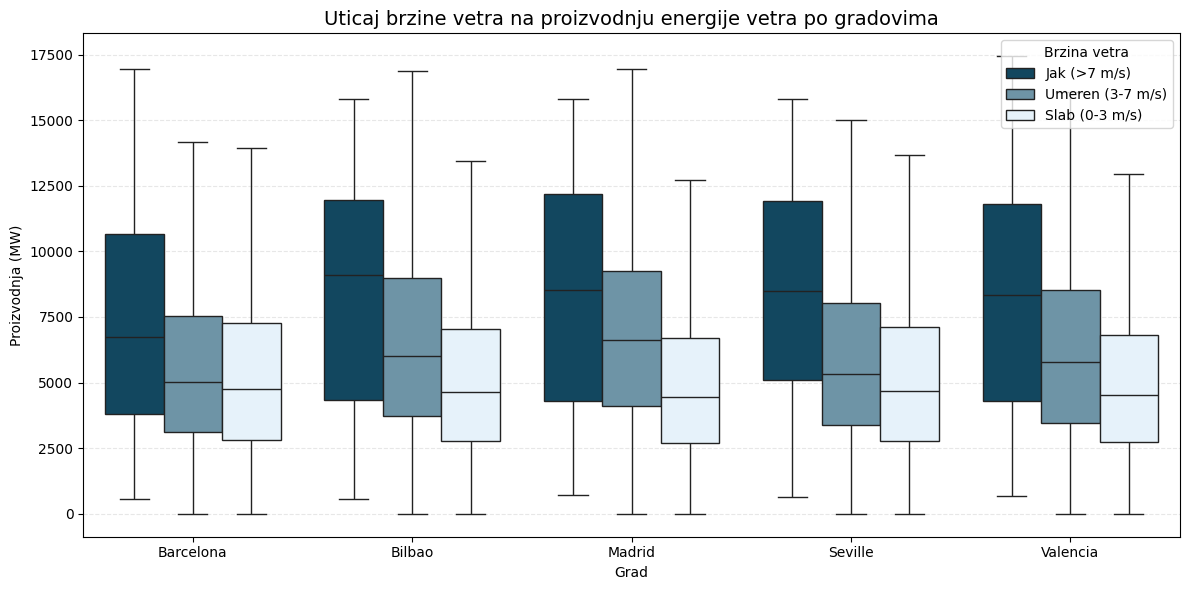

In [ ]:
# 1. Priprema podataka
df_plot = df_final.copy()
df_plot['dt_iso'] = pd.to_datetime(df_plot['dt_iso'], utc=True)
df_plot.set_index('dt_iso', inplace=True)
df_plot.index = df_plot.index.tz_localize(None)

df_filtered = df_plot.copy() 

if len(df_filtered) > 0:
    # 2. Kolone za brzinu vetra
    wind_cols = ['wind_speed_Barcelona', 'wind_speed_Bilbao', 'wind_speed_Madrid', 'wind_speed_Seville', 'wind_speed_Valencia']
    
    # 3. Topljenje podataka
    df_melted = df_filtered.melt(id_vars=['generation wind onshore'], 
                                 value_vars=wind_cols, 
                                 var_name='Grad', 
                                 value_name='Brzina_vetra')
    
    df_melted['Grad'] = df_melted['Grad'].str.replace('wind_speed_', '')

    # 4. Kategorizacija - BITNO: binovi moraju odgovarati labelama
    # Za labelu "Jak" bin mora biti (7, 100], za "Slab" (0, 3]
    # Prvo pravimo logičan redosled kategorija
    df_melted['Kategorija Vetra'] = pd.cut(df_melted['Brzina_vetra'], 
                                           bins=[-1, 3, 7, 100], 
                                           labels=['Slab (0-3 m/s)', 'Umeren (3-7 m/s)', 'Jak (>7 m/s)'])

    # 5. Podešavanje palete i redosleda za vizualizaciju
    # Želimo: Jak (Tamna), Umeren (Srednja), Slab (Svetla)
    redosled = ['Jak (>7 m/s)', 'Umeren (3-7 m/s)', 'Slab (0-3 m/s)']
    wind_palette = ["#054C6C", "#6497B0", "#E3F2FD"] # Obrnut redosled boja (Tamna -> Svetla)

    # 6. Crtanje
    plt.figure(figsize=(12, 6)) # Prvo pravimo figuru
    
    sns.boxplot(x='Grad', y='generation wind onshore', 
                hue='Kategorija Vetra', 
                hue_order=redosled, # Redosled boxplotova: Jak, Umeren, Slab
                data=df_melted, 
                palette=wind_palette, 
                showfliers=False)

    plt.title('Uticaj brzine vetra na proizvodnju energije vetra po gradovima', fontsize=14)
    plt.ylabel('Proizvodnja (MW)')
    plt.xlabel('Grad')
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.legend(title='Brzina vetra', loc='upper right')
    
    plt.tight_layout()
    plt.show()
else:
    print("Nema podataka za prikaz.")

Mala razlika za 'Slab' i 'Umeren' vetar ukazuje na to da povećanje brzine vetra  uopšte ne utiče na proizvodnju ( > 3 ms) kada turbine zapravo počinju da proizvode energiju. Te pojave su najviše uočljive za gradove Barselonu i Sevilju, dok povećanje brzine vetra u Madridu i Bilbau najviše utiče na proizvodnju vetroenergije.

## Potrošnja

U nastavku su dati grafici i neki zaključci koji se odnose na potrošnju električne energije. 

### Zavisnost potrošnje od vremena (sat, dan, mjesec)

19


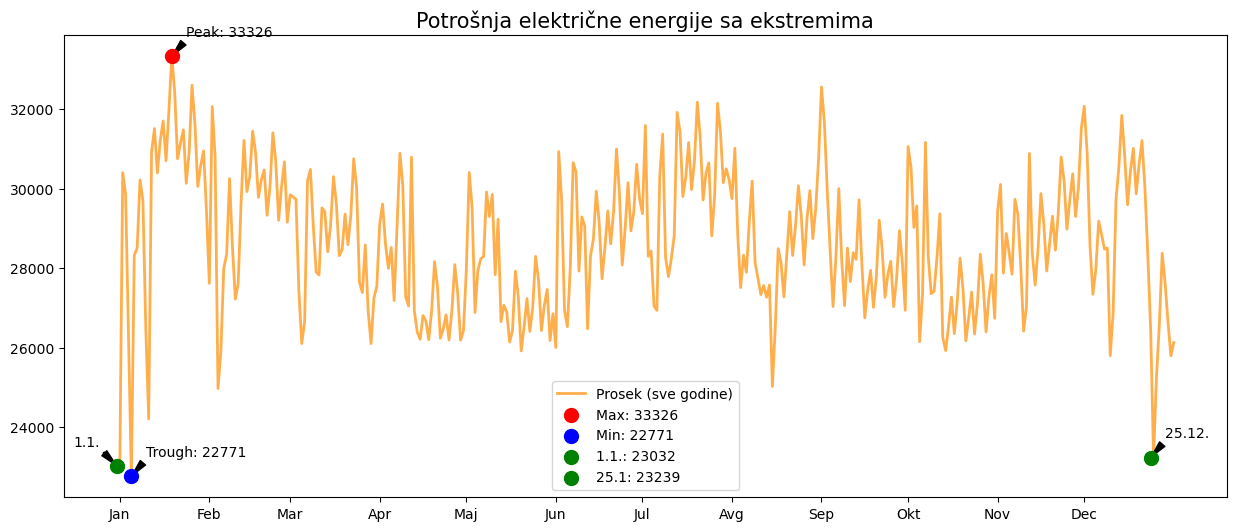

In [53]:
plt.figure(figsize=(15, 6))
plt.plot(df_average['Day_of_Year'], df_average['total load actual'], color='#FF8C00', label='Prosek (sve godine)', linewidth=2, alpha=0.7)

# Pronalaženje max i min unutar agregiranih podataka (df_average)
max_val = df_average['total load actual'].max()
max_day = df_average.loc[df_average['total load actual'].idxmax(), 'Day_of_Year']
print(max_day)
min_val = df_average['total load actual'].min()
min_day = df_average.loc[df_average['total load actual'].idxmin(), 'Day_of_Year']

# Dodavanje tačaka na grafik
plt.scatter(max_day, max_val, color='red', s=100, zorder=5, label=f'Max: {max_val:.0f}')
plt.scatter(min_day, min_val, color='blue', s=100, zorder=5, label=f'Min: {min_val:.0f}')
plt.scatter(0, df_average['total load actual'].iat[0], color='green', s=100, zorder=5, label=f'1.1.: {df_average['total load actual'].iat[0]:.0f}')
plt.scatter(358, df_average['total load actual'].iat[358], color='green', s=100, zorder=5, label=f'25.1: {df_average['total load actual'].iat[358]:.0f}')

plt.annotate(f'Peak: {max_val:.0f}', xy=(max_day, max_val), xytext=(max_day+5, max_val+500),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.annotate(f'Trough: {min_val:.0f}', xy=(min_day, min_val), xytext=(min_day+5, min_val+500),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.annotate(f'1.1.', xy=(0, df_average['total load actual'].iat[0]), xytext=(-15, df_average['total load actual'].iat[0]+500),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.annotate(f'25.12.', xy=(358, df_average['total load actual'].iat[358]), xytext=(358+5, df_average['total load actual'].iat[358]+500),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))

plt.xticks(ticks=[1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335],
           labels=['Jan', 'Feb', 'Mar', 'Apr', 'Maj', 'Jun', 'Jul', 'Avg', 'Sep', 'Okt', 'Nov', 'Dec'])


plt.title('Potrošnja električne energije sa ekstremima', fontsize=15)
plt.legend()
plt.show()

Na grafiku iznad prikazana je dnevna potrošnja u toku godine.

Takođe ispod grafika se nalaze vrednosti za minimalnu i maksimalnu potrošnju.
Mininalna potrošnja u desila se 6. januara. Takođe 1. januara potrošnja električne energije približna je minimalnoj. Ta dva dana su neradni dani u Španiji te je sasvim normanlo da je tih dana potrošnja drastično manja jer se većina industrijskih postrojenja gasi tih dana.
Zaninimljivo je vidjeti da i na kraju godine imamo značajan pad i to baš 25. decembra kada se u Španiji obilježava Božić.

Najveća potrošnja zabeležena je 20. januara. Jedan od razloga za to može biti to što je Španiju toga dana 2017. godine pogodila snežna oluja koja je donela sneg i na mediteransku obalu [link](https://watchers.news/2017/01/20/eastern-spain-snow-january-2017/?utm_source=chatgpt.com).

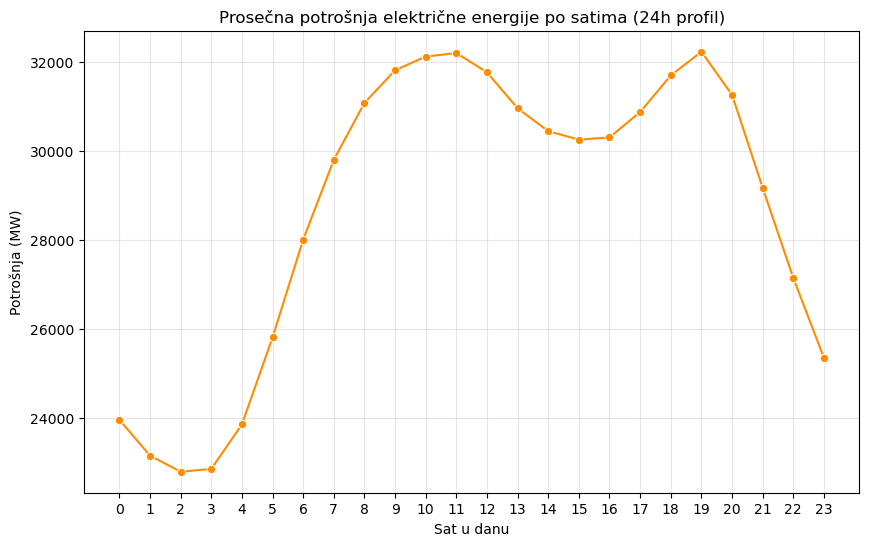

In [17]:
df_load = df_final.copy()

df_load['dt_iso'] = pd.to_datetime(df_load['dt_iso'])
df_load['hour'] = df_load['dt_iso'].dt.hour

hourly_avg = df_load.groupby('hour')['total load actual'].mean()

plt.figure(figsize=(10, 6))
sns.lineplot(x=hourly_avg.index, y=hourly_avg.values, marker='o', color='darkorange')
plt.title('Prosečna potrošnja električne energije po satima (24h profil)')
plt.xlabel('Sat u danu')
plt.ylabel('Potrošnja (MW)')
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3)
plt.show()


Na dijagramu iznad mozemo vidjeti prosječnu potrošnju električne energije u toku dana.
Kao što možemo vidjeti najviše električne energije se potroši u popodnevnim časovima što je bilo i očekivano. Najveću vrijednost dostiže u 11 i 19 časova što takođe ima smisla jer ljudi pripremaju obroke, pale klima uredjaje...

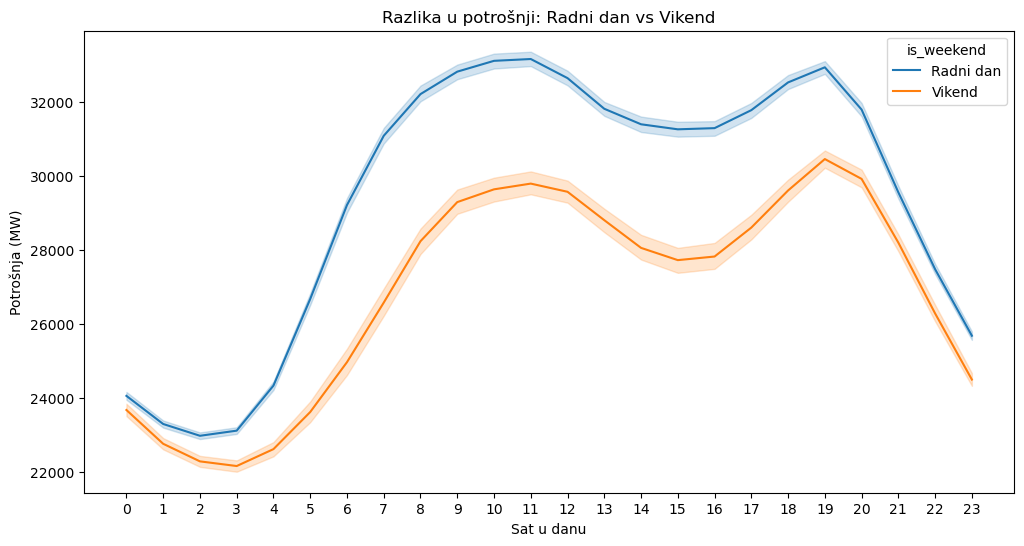

In [18]:
df_load['day_of_week'] = df_load['dt_iso'].dt.dayofweek
df_load['is_weekend'] = df_load['day_of_week'].apply(lambda x: 'Vikend' if x >= 5 else 'Radni dan')

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_load, x='hour', y='total load actual', hue='is_weekend', estimator='mean')
plt.title('Razlika u potrošnji: Radni dan vs Vikend')
plt.xlabel('Sat u danu')
plt.ylabel('Potrošnja (MW)')
plt.xticks(range(0, 24))
plt.show()

Gledajući po satima radni dani i vikend imaju jako sličan trend ponašanja s tim da je amplituda za potrošnju u toku radnog dijela veća što je i za očekivati.

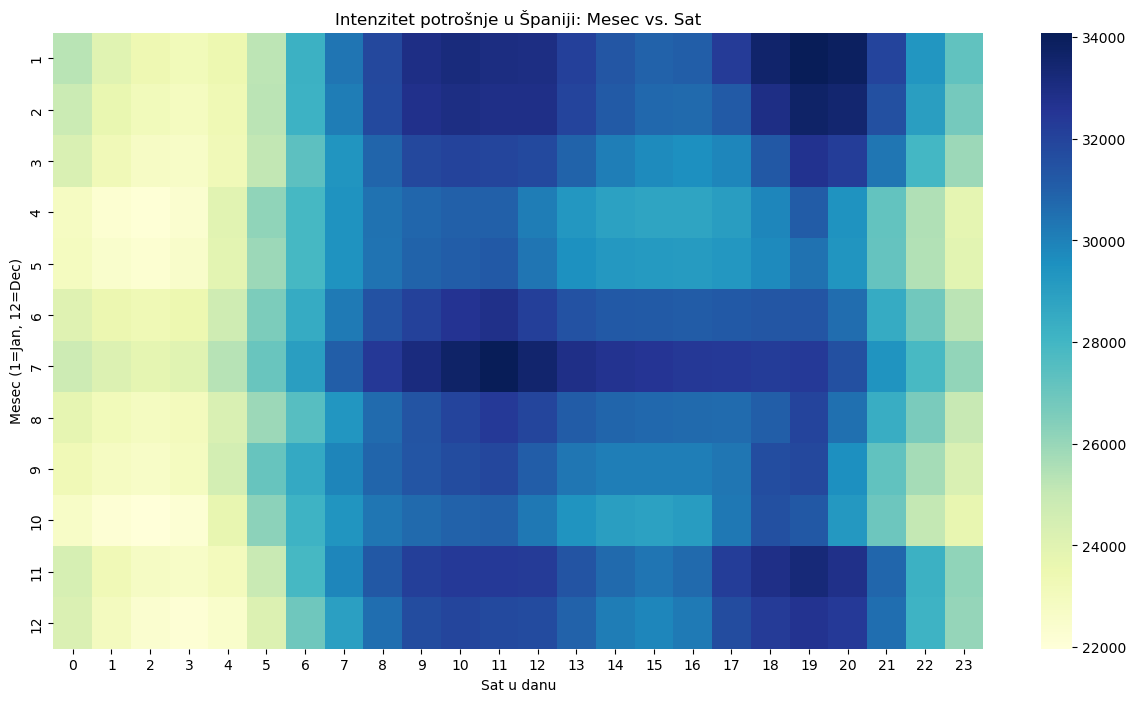

In [19]:
heatmap_data = df_load.groupby([df_load['dt_iso'].dt.month, 'hour'])['total load actual'].mean().unstack()

plt.figure(figsize=(15, 8))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=False)
plt.title('Intenzitet potrošnje u Španiji: Mesec vs. Sat')
plt.ylabel('Mesec (1=Jan, 12=Dec)')
plt.xlabel('Sat u danu')
plt.show()

Sa grafika koji je prikazan iznad možemo videti da je potrošnja elekrične energije najveća tokom ljetnjih i zimskih meseci. Veliki utucaj na to najverovatnije imaju toplotni i rashladni uređaji koji se koriste u tom periodu kako za prostorije tako i za različita postrojenja.

U 11 časova u toku jula i 19 časova u toku mjeseca januara zabilježena je najveća potrošnja. Na jednom od prethodnih grafika primećeno je da je najveća potoršnja upravo u tim delovima dana. Razlog zbog čega je potrošnja najveća baš u januaru i julu može se pripisati vremenskim uslovima, januar kao najhladniji mjesec i jul kao najtopliji mesec u godini.

### Potrošnja i proizvodnja (solarna i vjetro energija)

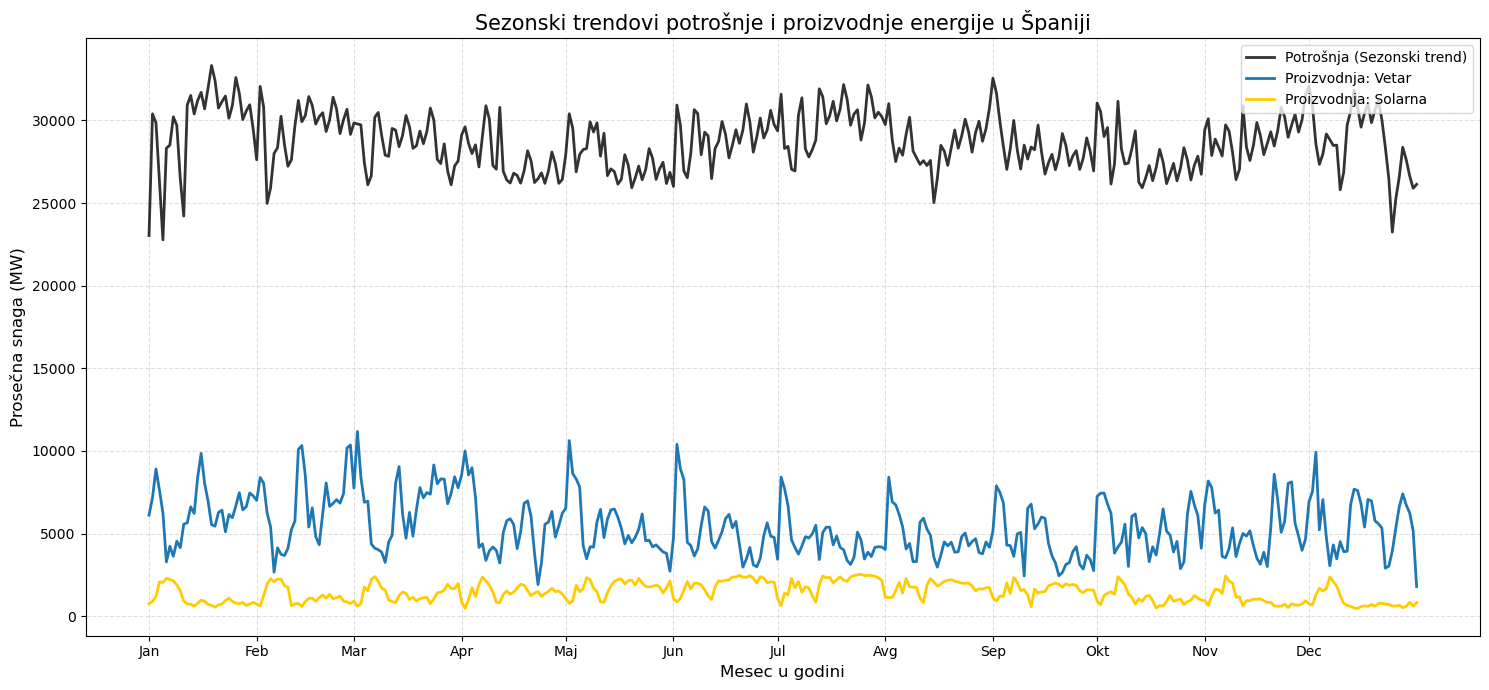

In [ ]:
daily_seasonal = df_line.groupby('Day_of_Year')[['total load actual', 'generation wind onshore', 'generation solar']].mean()

plt.figure(figsize=(15, 7))

plt.plot(daily_seasonal.index, daily_seasonal['total load actual'], 
         label='Potrošnja (Sezonski trend)', color='black', linewidth=2, alpha=0.8)
plt.plot(daily_seasonal.index, daily_seasonal['generation wind onshore'], 
         label='Proizvodnja: Vetar', color='#1f77b4', linewidth=2)
plt.plot(daily_seasonal.index, daily_seasonal['generation solar'], 
         label='Proizvodnja: Solarna', color='#ffcc00', linewidth=2)

plt.xticks(ticks=[1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335],
           labels=['Jan', 'Feb', 'Mar', 'Apr', 'Maj', 'Jun', 'Jul', 'Avg', 'Sep', 'Okt', 'Nov', 'Dec'])

plt.title('Sezonski trendovi potrošnje i proizvodnje energije u Španiji', fontsize=15)
plt.xlabel('Mesec u godini', fontsize=12)
plt.ylabel('Prosečna snaga (MW)', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

Kao što je bilo i za očekivati svega 25% potrošene električne energije dolazi iz obnoviljvih izvora (~20% vjetar, ~5% sunce). 

Proizvodnja vetroelektrana drastično skače i pada iz dana u dan. Može da padne skoro na nulu, a može da skoči preko 10.000 MW (kao što se vidi u martu i maju). Vidi se da je vetar generalno jači u prvoj polovini godine (januar–maj) nego u letnjim mesecima.

Za električnu energiju proizvedenu iz sunčeve energije vidi se postepeni uspon koji dostiže maksimum u julu i avgustu, dok je najniža u novembru i decembru. Zanimljivo je da je "vrh" solarne proizvodnje relativno ravan tokom leta, što znači da Španija ima mnogo stabilnih sunčanih dana bez previše oblaka u tom periodu.

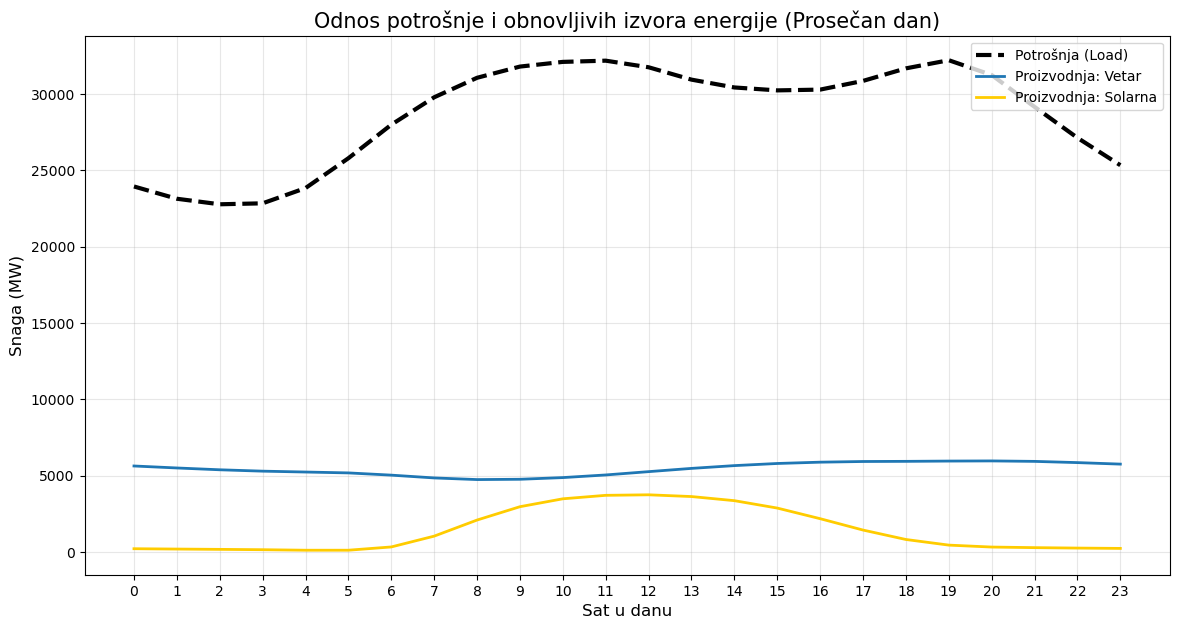

In [ ]:
# Grupisanje po satu za sve tri kategorije
hourly_comparison = df_load.groupby('hour')[['total load actual', 'generation wind onshore', 'generation solar']].mean()

plt.figure(figsize=(14, 7))

plt.plot(hourly_comparison.index, hourly_comparison['total load actual'], 
         label='Potrošnja (Load)', color='black', linewidth=3, linestyle='--')
plt.plot(hourly_comparison.index, hourly_comparison['generation wind onshore'], 
         label='Proizvodnja: Vetar', color='#1f77b4', linewidth=2)
plt.plot(hourly_comparison.index, hourly_comparison['generation solar'], 
         label='Proizvodnja: Solarna', color='#ffcc00', linewidth=2)

plt.title('Odnos potrošnje i obnovljivih izvora energije (Prosečan dan)', fontsize=15)
plt.xlabel('Sat u danu', fontsize=12)
plt.ylabel('Snaga (MW)', fontsize=12)
plt.xticks(range(0, 24))
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.show()

Proizvodnja solatnih elektrana raste u toku dana, kao i sama potrošnja. Ukoliko su ispunjeni vremenski uslovi za rad solarnih elektrana u periodu od 8-15 časova možemo se osloniti na energiju koja dolazi iz ovog izvora.

Sa druge stane vetroelektrane proizvode prilično stabilnu energiju u toku jednog dana, problem je u tome što ova proizvodnja može drastično varirati izmedju dva dana što smo vidjeli na nekom od prethodnih grafika.

### Potrošnja i temperatura

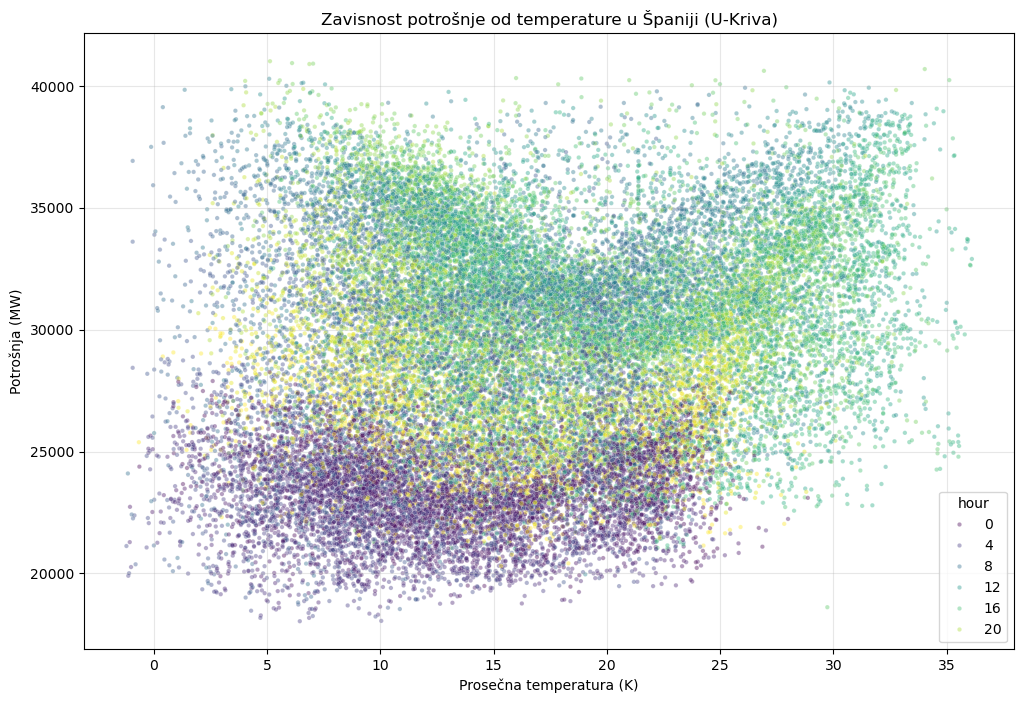

In [ ]:
# Izračunavanje prosečne temperature za 5 gradova
temp_cols = ['temp_Madrid', 'temp_Barcelona', 'temp_Valencia', 'temp_Seville', 'temp_Bilbao']
df_load['avg_temp'] = df_load[temp_cols].mean(axis=1) - 273.15

plt.figure(figsize=(12, 8))
# Koristimo 'hue' da obojimo tačke po satima ili mesecima
sns.scatterplot(data=df_load, x='avg_temp', y='total load actual', 
                hue='hour', palette='viridis', alpha=0.4, s=10)

plt.title('Zavisnost potrošnje od temperature u Španiji (U-Kriva)')
plt.xlabel('Prosečna temperatura (°C)')
plt.ylabel('Potrošnja (MW)')
plt.grid(True, alpha=0.3)
plt.show()

Ovaj dijagram nam pokazuje kako se potrošnja struje menja sa temperaturom. Tačke formiraju oblik slova 'U', što znači da trošimo najviše struje kada je jako hladno (grejanje) i kada je jako toplo (klima uređaji). Boje nam dodatno govore u koje doba dana je merenje izvršeno — ljubičaste tačke su noć, a žute su dan. Najmanje energije trošimo kada je napolju prijatno, između 15 °C i 22 °C, što se vidi kao najniža tačka u sredini ovog oblaka podataka

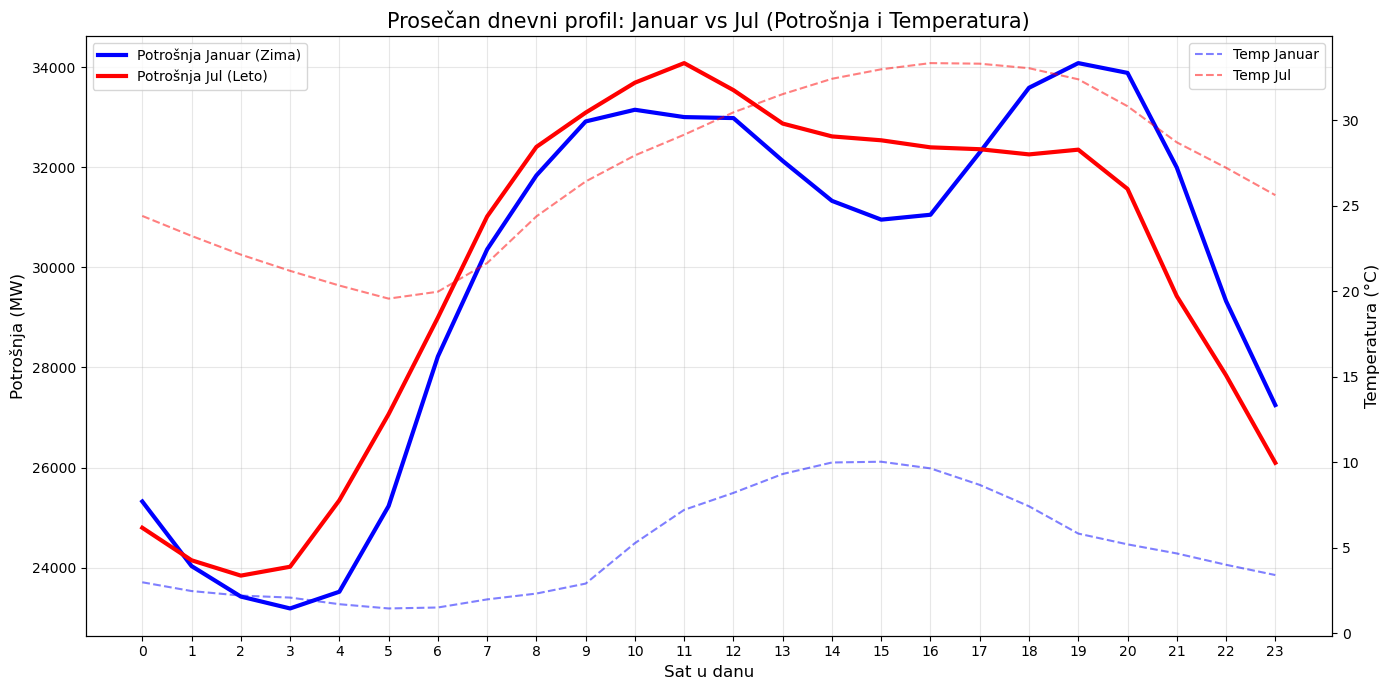

In [57]:
# Osiguraj da imaš kolone 'month' i 'hour'
df_load['month'] = df_load['dt_iso'].dt.month
df_load['hour'] = df_load['dt_iso'].dt.hour

# Izdvajanje proseka za Januar (1) i Jul (7)
january_avg = df_load[df_load['month'] == 1].groupby('hour')['total load actual'].mean()
july_avg = df_load[df_load['month'] == 7].groupby('hour')['total load actual'].mean()

# Izdvajanje temperature (npr. Madrid) za iste mesece radi poređenja
january_temp = df_load[df_load['month'] == 1].groupby('hour')['temp_Madrid'].mean() - 273.15
july_temp = df_load[df_load['month'] == 7].groupby('hour')['temp_Madrid'].mean() - 273.15

fig, ax1 = plt.subplots(figsize=(14, 7))

# --- OSA 1: POTROŠNJA ---
ax1.plot(january_avg.index, january_avg.values, label='Potrošnja Januar (Zima)', color='blue', linewidth=3)
ax1.plot(july_avg.index, july_avg.values, label='Potrošnja Jul (Leto)', color='red', linewidth=3)
ax1.set_ylabel('Potrošnja (MW)', fontsize=12)
ax1.set_xlabel('Sat u danu', fontsize=12)
ax1.set_xticks(range(0, 24))

# --- OSA 2: TEMPERATURA ---
ax2 = ax1.twinx() 
ax2.plot(january_temp.index, january_temp.values, label='Temp Januar', color='blue', linestyle='--', alpha=0.5)
ax2.plot(july_temp.index, july_temp.values, label='Temp Jul', color='red', linestyle='--', alpha=0.5)
ax2.set_ylabel('Temperatura (°C)', fontsize=12)

# Naslov i legenda
plt.title('Prosečan dnevni profil: Januar vs Jul (Potrošnja i Temperatura)', fontsize=15)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Analiza prosečnog dnevnog profila za januar i jul jasno ukazuje na različite režime rada sistema.

U januaru je primetna snažna negativna korelacija između temperature i potrošnje: sa porastom dnevne temperature, potreba za grejanjem opada, što dovodi do smanjenja opterećenja mreže. Najniža potrošnja se poklapa sa temperaturnim maksimumom oko 15:00h.

Nasuprot tome, u julu vidimo efekat hlađenja. Potrošnja raste uporedo sa temperaturom tokom prepodneva, ali zadržava visok nivo i u najtoplijem delu dana zbog rada klima uređaja. Iako postoji blagi pad u popodnevnim časovima, on je znatno manje izražen nego u zimskom periodu